# Resnet with 3 residual layers<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py)

Change $C_i$: # channels in Residual Layer $i$

## Build Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
# import argparse

# from models import *
# from utils import progress_bar
import time
cur_time = time.time()
str_time = str(int(cur_time)) # used to rename file

### ResNet<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py)

$C_i$: # channels in Residual Layer $i$

$C = [64, 128, 192]$

In [2]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=4)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # self.linear = nn.Linear(512*block.expansion, num_classes)
        self.linear = nn.Linear(192*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet26():
    return ResNet(BasicBlock, [4, 5, 3])


def test():
    net = ResNet26()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

test()

torch.Size([1, 10])


### Total Trainable Parameters

In [3]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
net = ResNet26()
net = net.to(device)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

### Model Criterion and Optimizer

In [4]:
# Model
print('==> Building model..')
# net = ResNet(BasicBlock, [4, 5, 3])
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

'''if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']'''

criterion = nn.CrossEntropyLoss()
'''optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)'''
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= 200)

==> Building model..


## Preparing Data<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)



In [5]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:13<00:00, 13060050.13it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define Train Function<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)

In [6]:
# Training
def train(epoch):
    # print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        '''progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' 
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))'''
    aver_train_loss = float(train_loss/(batch_idx+1))
    aver_train_accuracy = float(correct/total)
    return aver_train_loss, aver_train_accuracy

## Define Test Function<sup>[[1]](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py)

In [7]:
best_acc = 0  # best test accuracy
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            '''progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' 
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))'''

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        # print('Saving..')
        state = {'net': net.state_dict(), 'acc': acc, 'epoch': epoch,}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_' + str_time + '.pth')
        best_acc = acc

    aver_test_loss = float(test_loss / (batch_idx + 1))
    aver_test_accuracy = float(correct / total)
    return aver_test_loss, aver_test_accuracy

## Train and Test

In [8]:
import json
import collections

EPOCH = 200
start_epoch = 0 # start from epoch 0 or last checkpoint epoch
JSON_FILE = './epoch_data_Resnet_cos_steplr_'+ str_time +'.json'
epoch_data = collections.OrderedDict()
for epoch in range(start_epoch, start_epoch+EPOCH):
    train_loss, train_accuracy = train(epoch)
    epoch_data[epoch] = {'train_loss': train_loss, 'train_accuracy': train_accuracy}
    test_loss, test_accuracy = test(epoch)
    epoch_data[epoch]['test_loss'], epoch_data[epoch]['test_accuracy'] = test_loss, test_accuracy
    scheduler.step()
    if epoch % 10 == 9:
      print(f'Epoch {epoch+1}/{EPOCH}, Train Loss {train_loss:.3f}, Train Acc {train_accuracy:.3f}, Test Loss {test_loss:.3f}, Test Acc {test_accuracy:.3f}')

epoch_data_json = json.dumps(epoch_data)
json_file = open(JSON_FILE, 'w')
json_file.write(epoch_data_json)
json_file.close()
print(f'Best Acc: {best_acc}%')

Epoch 10/200, Train Loss 0.536, Train Acc 0.815, Test Loss 0.659, Test Acc 0.771
Epoch 20/200, Train Loss 0.427, Train Acc 0.854, Test Loss 0.585, Test Acc 0.806
Epoch 30/200, Train Loss 0.382, Train Acc 0.869, Test Loss 0.531, Test Acc 0.826
Epoch 40/200, Train Loss 0.363, Train Acc 0.877, Test Loss 0.893, Test Acc 0.736
Epoch 50/200, Train Loss 0.340, Train Acc 0.884, Test Loss 0.855, Test Acc 0.760
Epoch 60/200, Train Loss 0.314, Train Acc 0.894, Test Loss 0.497, Test Acc 0.832
Epoch 70/200, Train Loss 0.288, Train Acc 0.903, Test Loss 0.374, Test Acc 0.875
Epoch 80/200, Train Loss 0.272, Train Acc 0.908, Test Loss 0.474, Test Acc 0.851
Epoch 90/200, Train Loss 0.245, Train Acc 0.916, Test Loss 0.379, Test Acc 0.876
Epoch 100/200, Train Loss 0.214, Train Acc 0.925, Test Loss 0.312, Test Acc 0.894
Epoch 110/200, Train Loss 0.190, Train Acc 0.934, Test Loss 0.352, Test Acc 0.887
Epoch 120/200, Train Loss 0.161, Train Acc 0.945, Test Loss 0.369, Test Acc 0.887
Epoch 130/200, Train Loss

## Data Analysis<sup>

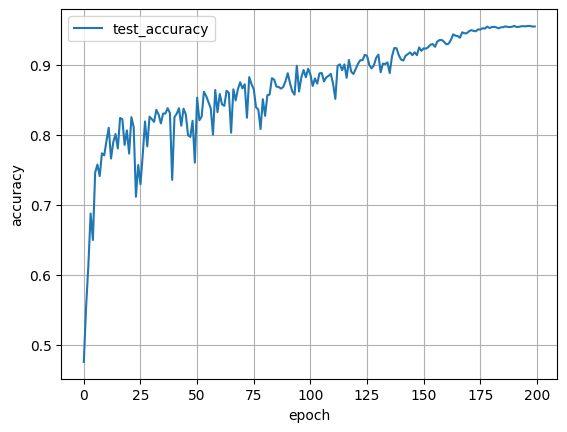

In [9]:
import matplotlib.pyplot as plt

f = open(JSON_FILE)
data1 = json.load(f)
f.close()

FEATURE = 'test_accuracy'

x = [i for i in range(EPOCH)]
feature1 = [data1[str(k)][FEATURE] for k in range(EPOCH)]

plt.plot(x, feature1, label=FEATURE)
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.show()
